Simpy example

In [1]:
import pandas as pd
import numpy as np
import simpy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
wells_array = []
trucks_array = []
tanks_array = []


In [3]:
class FlowStation:
    def __init__(self,env,num_chargers,tanks_capacity,max_level, trucks_num):
        self.env = env
        self.dispenser = simpy.Resource(env,capacity= num_chargers)
        self.tanks = simpy.Container(env,init=0,capacity=tanks_capacity)
        self.max_level = max_level
        self.monitor_tank = env.process(self.monitor_tank(env,max_level))
        self.trucks = simpy.Resource(env,capacity=trucks_num)
        self.called = False
    def monitor_tank(self, env, max_level):
        while True:
            print(f'The tank has {self.tanks.level} bbl at {env.now}')
            tanks_array.append(pd.DataFrame({'date':[env.now],'level':[self.tanks.level]}))
            trucks_to_call = self.tanks.level / 250
            trucks_to_call = np.ceil(trucks_to_call).astype(int)
            
            if self.tanks.level >= 6000 and self.called==False:
                print(f'Calling {trucks_to_call} Trucks at {env.now}')
                self.called=True
                for i in range(trucks_to_call -1):
                    env.process(charge_trucks(env,self))
            if self.tanks.level <= 1000:
                self.called=False
            yield env.timeout(2)
            
trucks = simpy.Resource


def charge_trucks(env,flow_station):
    with flow_station.trucks.request() as truck_req:
        #Trucks delays 2 days to arrive
        yield truck_req
        yield env.timeout(2)
        print(f'Truck has arrived at {env.now}')
        with flow_station.dispenser.request() as req:
            yield req
            print(f'Trucks started to load oil at {env.now}')
            yield flow_station.tanks.get(250)
            trucks_array.append(pd.DataFrame({'date':[env.now],'volume':[250]}))
            yield env.timeout(0.2)
            print(f'Trucks ended to load oil at {env.now}')

            


def well(name,env,flow_station,rate):
    while True:
        yield env.timeout(1)
        if flow_station.tanks.level < flow_station.max_level:
            print(f'Well {name} producing at a {rate} bbl/d {env.now}')
            yield flow_station.tanks.put(rate)
            wells_array.append(pd.DataFrame({'date':[env.now],'rate':[rate],'well':[name]}))
        else:
            print(f'Well {name} not produced at {env.now}')
            wells_array.append(pd.DataFrame({'date':[env.now],'rate':[0],'well':[name]}))
            
        

def well_generator(env,flow_station, wells_num):
    rates = np.random.uniform(low=100, high=200, size=wells_num)
    for i,r in enumerate(rates):
        env.process(well(i,env,flow_station,r))
    yield env.timeout(1)
        


In [4]:
env = simpy.Environment()
flow_station = FlowStation(env,2,10000,10000,25)
well_gen = env.process(well_generator(env,flow_station,4))
env.run(until=90)
wells_df = pd.concat(wells_array, axis=0)
tanks_df = pd.concat(tanks_array, axis=0)
trucks_df = pd.concat(trucks_array, axis=0)

The tank has 0 bbl at 0
Well 0 producing at a 153.2219412080356 bbl/d 1
Well 1 producing at a 161.48019368076774 bbl/d 1
Well 2 producing at a 105.5874890733938 bbl/d 1
Well 3 producing at a 188.85874237185698 bbl/d 1
The tank has 609.1483663340541 bbl at 2
Well 0 producing at a 153.2219412080356 bbl/d 2
Well 1 producing at a 161.48019368076774 bbl/d 2
Well 2 producing at a 105.5874890733938 bbl/d 2
Well 3 producing at a 188.85874237185698 bbl/d 2
Well 0 producing at a 153.2219412080356 bbl/d 3
Well 1 producing at a 161.48019368076774 bbl/d 3
Well 2 producing at a 105.5874890733938 bbl/d 3
Well 3 producing at a 188.85874237185698 bbl/d 3
The tank has 1827.4450990021624 bbl at 4
Well 0 producing at a 153.2219412080356 bbl/d 4
Well 1 producing at a 161.48019368076774 bbl/d 4
Well 2 producing at a 105.5874890733938 bbl/d 4
Well 3 producing at a 188.85874237185698 bbl/d 4
Well 0 producing at a 153.2219412080356 bbl/d 5
Well 1 producing at a 161.48019368076774 bbl/d 5
Well 2 producing at a 

<AxesSubplot:xlabel='date', ylabel='rate'>

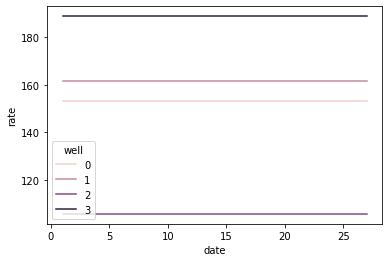

In [5]:
sns.lineplot(data=wells_df, x='date',y='rate',hue='well')

<AxesSubplot:xlabel='date', ylabel='level'>

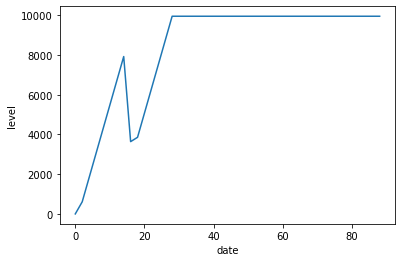

In [6]:
sns.lineplot(data=tanks_df, x='date',y='level')

<AxesSubplot:xlabel='date', ylabel='volume'>

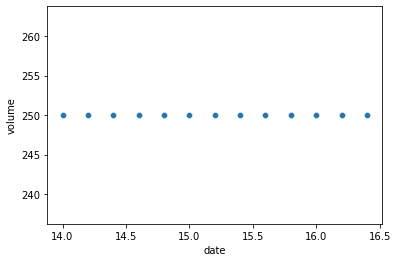

In [7]:
sns.scatterplot(data=trucks_df, x='date',y='volume')

In [8]:
trucks_df.count()

date      26
volume    26
dtype: int64